In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import spacy
import en_core_web_sm
import warnings 
import gensim
import time
import re
import os
import random
import dask
import dask.dataframe as dd
import seaborn as sns
import multiprocessing
import warnings
from wordcloud import WordCloud, STOPWORDS  # used to generate world cloud
from nltk.tokenize import sent_tokenize, word_tokenize, regexp_tokenize
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from collections import Counter
from collections import defaultdict  # For word frequency
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sns.set_style("darkgrid")
warnings.filterwarnings(action = 'ignore') 

# 1. Loading the data

In [165]:
%%time
data = pd.DataFrame()
for root, dirs, files in os.walk("./data/"):
        for file in files:
            if file.endswith(".csv"):
                data = data.append(pd.read_csv("./data/" + file))
data = data.iloc[:, 2:-7] # removing the columns, we will not work on
print(data.shape)
data.head()

(2946207, 12)
Wall time: 32.1 s


,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,retweet,account_category
0,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,RightTroll
1,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,NaN,Right,0,RightTroll
2,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,RETWEET,Right,1,RightTroll
3,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,NaN,Right,0,RightTroll
4,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,RETWEET,Right,1,RightTroll


In [166]:
data.columns

Index(['content', 'region', 'language', 'publish_date', 'harvested_date',
       'following', 'followers', 'updates', 'post_type', 'account_type',
       'retweet', 'account_category'],
      dtype='object')

In [167]:
data = data.drop(columns=['updates', 'post_type'])

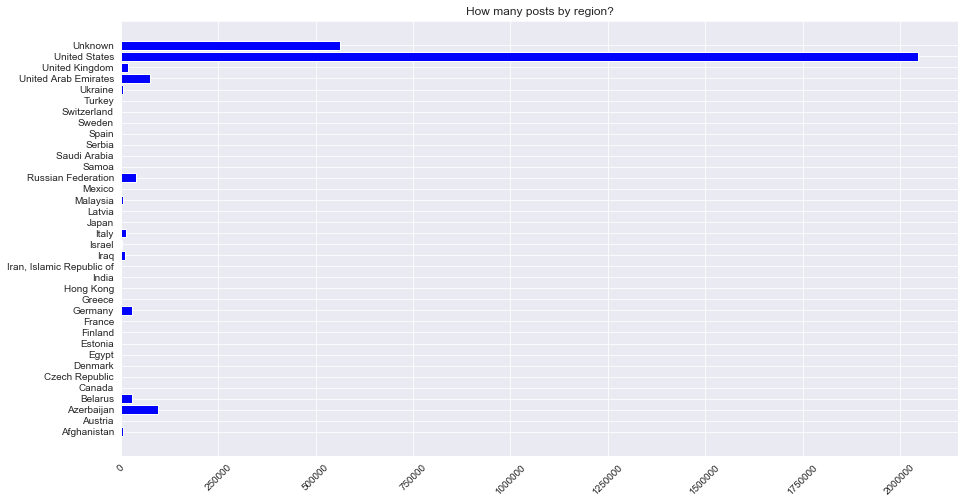

In [168]:
postsByRegion = data.groupby('region')['content'].count().reset_index(name='count')
plt.figure(figsize=(15, 8))
plt.barh(postsByRegion['region'], postsByRegion['count'], color='blue')
plt.title("How many posts by region?")
plt.xticks(rotation=45)
plt.show()

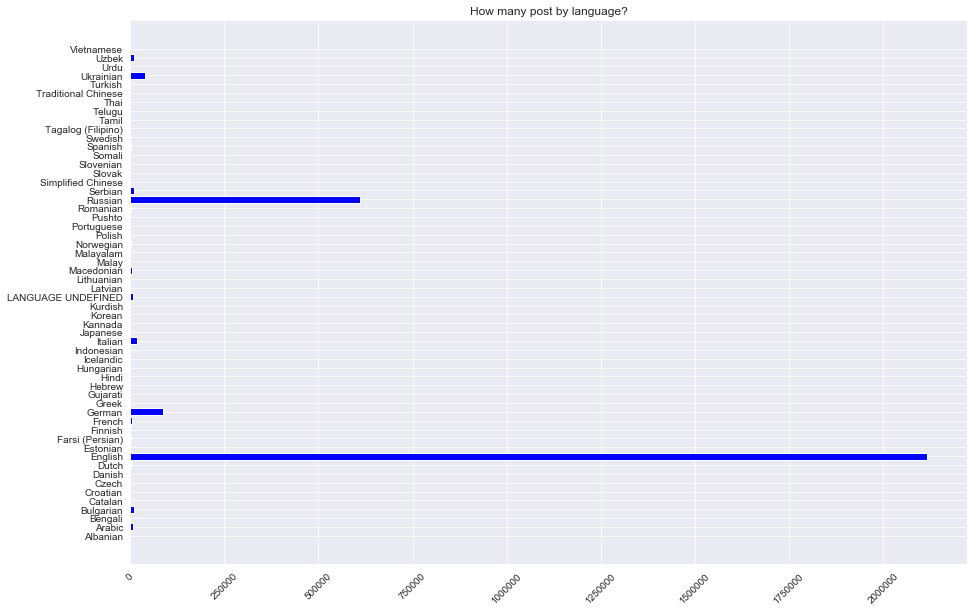

In [169]:
postsByLanguage = data.groupby('language')['content'].count().reset_index(name='count')
plt.figure(figsize=(15, 10))
plt.barh(postsByLanguage['language'], postsByLanguage['count'], color='blue')
plt.title("How many post by language?")
plt.xticks(rotation=45)
plt.show()

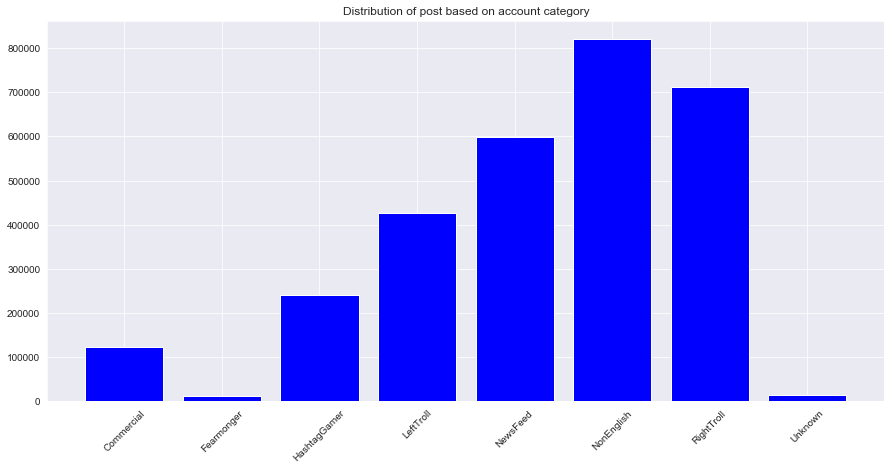

In [170]:
postsByType = data.groupby('account_category')['content'].count().reset_index(name='count')
plt.figure(figsize=(15, 7))
plt.bar(postsByType['account_category'], postsByType['count'], color='blue')
plt.title("Distribution of post based on account category")
plt.xticks(rotation=45)
plt.show()

# 2. Cleaning/pre-processing

In [171]:
start_time = time.time()

In [172]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

12

### Work with English language only

In [173]:
data['language'].unique()

array(['English', 'Russian', 'Serbian', 'Ukrainian', 'Tagalog (Filipino)',
       'Albanian', 'Italian', 'Romanian', 'Spanish', 'Catalan', 'German',
       'Estonian', 'French', 'Norwegian', 'Vietnamese', 'Dutch', 'Arabic',
       'Uzbek', 'Bulgarian', 'Macedonian', 'Farsi (Persian)', 'Turkish',
       'LANGUAGE UNDEFINED', 'Czech', 'Somali', 'Lithuanian', 'Croatian',
       'Slovak', 'Icelandic', 'Slovenian', 'Japanese', 'Indonesian',
       'Pushto', 'Hungarian', 'Finnish', 'Latvian', 'Portuguese',
       'Danish', 'Swedish', 'Malay', 'Polish', 'Korean', 'Hebrew', 'Urdu',
       'Kurdish', 'Hindi', 'Greek', 'Simplified Chinese', 'Thai',
       'Gujarati', 'Bengali', 'Traditional Chinese', 'Kannada', 'Tamil',
       'Telugu', 'Malayalam'], dtype=object)

In [174]:
data = data[data.language=='English']
print(data.shape)

(2116867, 10)


- Only considering the English language

### Check null values

In [175]:
data.isnull().sum()

content                1
region              1136
language               0
publish_date           0
harvested_date         0
following              0
followers              0
account_type           0
retweet                0
account_category       0
dtype: int64

In [176]:
data = data.dropna(subset=['content'])

- We will work with the content of each tweets, and it has only 1 null value, so we're gonna ignore it

### Remove urls, stopwords, non-alphabetic-characters, words less than 3 character and lemmatize

### Remove email address

In [177]:
def remove_emails(text):
    '''
    Remove any email address in text with
    
    The `regex` can catch any number of email addresses in the text. Regex can be tried here: https://regex101.com/r/ZjgyLc/2
    '''
    regex =  r'\S*@\S*\s?'
    return re.sub(regex, ' ', text)

### Tokenization

In [178]:
def tokenize(text):
    '''
    Tokenize text
    '''
    tokens = nltk.word_tokenize(text)
    
    return list(
        filter(lambda word: word.isalnum(), tokens)
    )

### Removing Newline characters

In [179]:
def remove_newlinechars(text):
    '''
    Substitute any newline chars with a whitespach
    
    The `regex` can be tried at: https://regex101.com/r/2fImPz/1/
    '''
    regex = r'\s+'
    return re.sub(regex, ' ', text)

### Removing stop words

In [181]:
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
stop_words.extend(["from","subject","summary","keywords", "article"])
## Add some common words from text
def remove_stopwords(words):
    '''
    Remove stop words from the list of words
    '''
    filtered = filter(lambda word: word not in stop_words, words)
    
    return list(filtered)

### Lemmatization

In [182]:
nlp = en_core_web_sm.load()

def lemmatize(text):
    doc = nlp(" ".join(text))
    
    lemmatized = [token.lemma_ for token in doc]
    
    return lemmatized

In [183]:
def clean_text(df):
    '''
    Take in a Dataframe, and process it
    '''
    
    df["content"] = df.content.map(lambda text:text.lower()).map(remove_emails).map(remove_newlinechars).map(tokenize).map(remove_stopwords).map(lemmatize)
    return df

In [184]:
# daf = pd.read_csv("temp.csv")
# dask_df = dd.from_pandas(daf, npartitions=6)
# result = dask_df.map_partitions(clean_text, meta=daf)
# df_n = result.compute()
# df_n.head()

In [185]:
# %%time
# dask_df = dd.from_pandas(data, npartitions=12)
# dask_df.head()

In [186]:
# %%time
# result = dask_df.map_partitions(clean_text, meta=data)
# df_dask = result.compute()
# df_dask.head()

In [22]:
nlp = en_core_web_sm.load(disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [33]:
%%time
brief_cleaning = (re.sub("[^A-Za-z]+", ' ', (re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', ' ', str(row)))).lower() for row in data['content'])
textlist = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=10000, n_threads=cores-1)]

Wall time: 19min 34s


- Taking advantage of spaCy .pipe() attribute to speed-up the cleaning process:

In [34]:
textlist = list(filter(None, textlist)) # removing the null tweets
textlist = [' '.join(w for w in word.split() if len(w)>2) for word in textlist] # removing words that has less than 3 alphabet

In [35]:
data_clean = pd.DataFrame({'clean': textlist})
data_clean = data_clean.dropna()
data_clean.shape

(2062883, 1)

In [36]:
data['content'].head()

0    "We have a sitting Democrat US Senator on tria...
1    Marshawn Lynch arrives to game in anti-Trump s...
2    Daughter of fallen Navy Sailor delivers powerf...
3    JUST IN: President Trump dedicates Presidents ...
4    19,000 RESPECTING our National Anthem! #StandF...
Name: content, dtype: object

In [37]:
data_clean['clean'].head()

0    sit democrat senator trial corruption barely h...
1    marshawn lynch arrive game anti trump shirt ju...
2    daughter fallen navy sailor deliver powerful m...
3    president trump dedicate presidents cup golf t...
4            respect national anthem standforouranthem
Name: clean, dtype: object

### Detecting the phrases

In [38]:
%%time
sentences = [row.split() for row in data_clean['clean']]
for i in range(5):
    print(sentences[i])

['sit', 'democrat', 'senator', 'trial', 'corruption', 'barely', 'hear', 'peep', 'mainstream', 'medium', 'nedryun']
['marshawn', 'lynch', 'arrive', 'game', 'anti', 'trump', 'shirt', 'judge', 'sag', 'pant', 'shirt', 'lynch', 'belt']
['daughter', 'fallen', 'navy', 'sailor', 'deliver', 'powerful', 'monologue', 'anthem', 'protest', 'burn', 'nfl', 'packers', 'gear', 'boycottnfl']
['president', 'trump', 'dedicate', 'presidents', 'cup', 'golf', 'tournament', 'trophy', 'people', 'florida', 'texas', 'puerto', 'rico']
['respect', 'national', 'anthem', 'standforouranthem']
Wall time: 4.41 s


In [43]:
# %%time
# phrases = Phrases(sentences, min_count=, progress_per=10000)
# len(phrases.vocab)

In [44]:
# %%time
# bigram = Phraser(phrases)
# sentences = bigram[sent]
# for i in range(5):
#     print(sentences[i])

- The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task.
- As we can see national and anthem were two different words, but they are merged into national_anthem (as phrase)

### What is the word frequency in the data after cleaning?

In [41]:
%%time
word_freq = defaultdict(int)
for sentence in sentences:
    for word in sentence:
        word_freq[word] += 1
len(word_freq)

Wall time: 3.71 s


700137

In [42]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['trump',
 'news',
 'new',
 'man',
 'police',
 'people',
 'say',
 'obama',
 'like',
 'world']

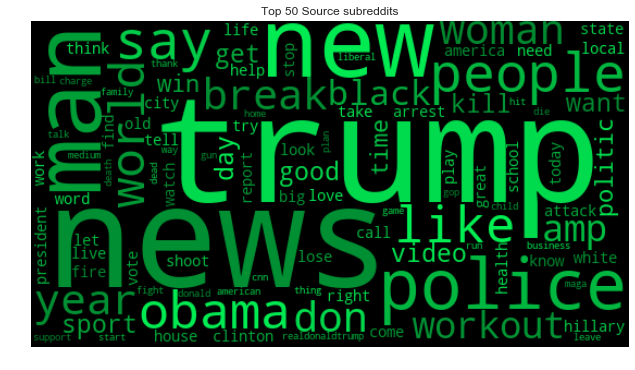

In [144]:
# Function that control the color of the words
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    tone = 100 # define the color of the words
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

f, ax = plt.subplots(figsize=(15, 6))
wordcloud = WordCloud(width=550, height=300, background_color='black', 
                      max_words=100, relative_scaling=0.6,
                      color_func = random_color_func,
                      normalize_plurals=True)
wordcloud.generate_from_frequencies(word_freq)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Top 50 Source subreddits")
plt.axis('off')
plt.show()

# 3. Training the model

In [45]:
w2v_model = Word2Vec(min_count=30, # words frequency to be considered
                     window=2, # skip-gram
                     size=300, # dimension of feature vector of each word
                     workers=cores-1) # number of cores to be used

In [46]:
%%time
w2v_model.build_vocab(sentences, progress_per=10000)

Wall time: 3.59 s


In [47]:
%%time
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=20)

Wall time: 3min 42s


(286548899, 322693860)

In [48]:
w2v_model.init_sims(replace=True)

- As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient

In [49]:
# w2v_model.save("./data/model/word2vec.model")

- saving the model for further use, so we don't have to generate again

# 4. Exploring the model

In [50]:
print(w2v_model)

Word2Vec(vocab=24747, size=300, alpha=0.025)


### Most similar to

In [51]:
w2v_model.wv.most_similar(positive=["trump"])

[('realdonaldtrump', 0.6481770873069763),
 ('obama', 0.6032754182815552),
 ('hillary', 0.5821034908294678),
 ('donald', 0.5501651167869568),
 ('potu', 0.5355900526046753),
 ('donaldtrump', 0.5218299031257629),
 ('sander', 0.5205485820770264),
 ('clinton', 0.5199545621871948),
 ('democrats', 0.504078209400177),
 ('trum', 0.48969075083732605)]

### Similarity

In [53]:
w2v_model.wv.similarity('king', 'queen')

0.33187395

### Odd-one-out

In [54]:
w2v_model.wv.doesnt_match(['vote', 'car', 'taxi', 'boat'])

'vote'

### Analogy difference

In [57]:
w2v_model.wv.most_similar(positive=["king", "man"], negative=["women"], topn=3)

[('cop', 0.42660605907440186),
 ('boyfriend', 0.4002225697040558),
 ('boy', 0.3913809359073639)]

### t-SNE visualizations
t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.

In [58]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 150 to 15 dimensions with PCA
    reduc = PCA(n_components=15).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

### 10 Most similar words vs. some random words

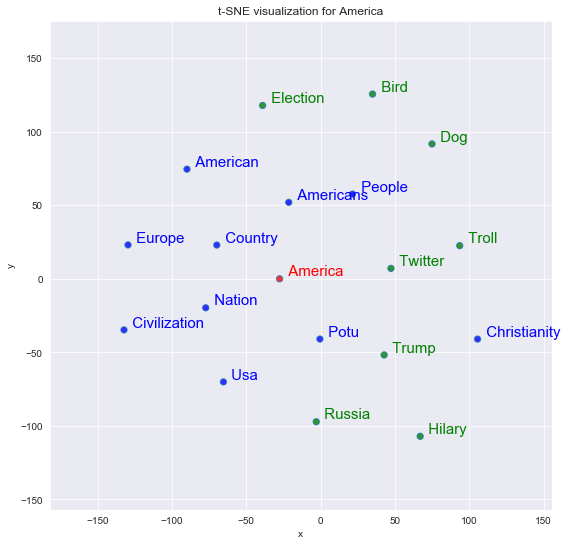

In [59]:
tsnescatterplot(w2v_model, 'america', ['dog', 'bird', 'trump', 'election', 'hilary', 'twitter', 'russia', 'troll'])

### 10 Most similar words vs. 10 most dissimilar

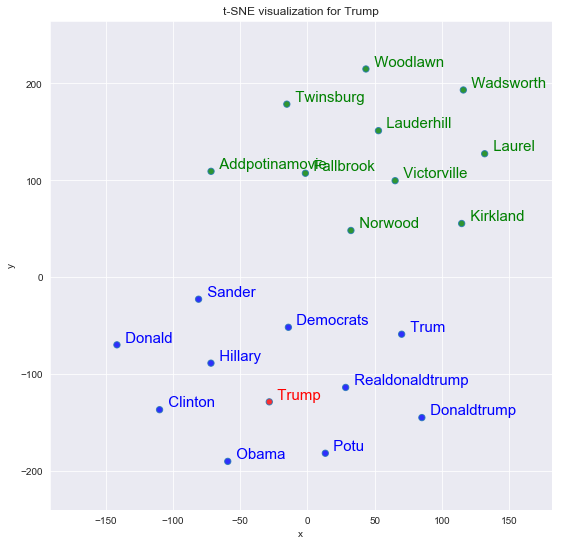

In [60]:
tsnescatterplot(w2v_model, 'trump', [i[0] for i in w2v_model.wv.most_similar(negative=["trump"])])

### Finding bias and random queries

In [61]:
w2v_model.wv.most_similar(positive=["nation"], topn=3)

[('country', 0.6588343381881714),
 ('america', 0.559099018573761),
 ('usa', 0.45157042145729065)]

In [63]:
w2v_model.wv.most_similar(positive=["country"], topn=3)

[('nation', 0.496705025434494),
 ('america', 0.47394198179244995),
 ('usa', 0.40449047088623047)]

- as we can see, the data is biased towards america

In [72]:
w2v_model.wv.most_similar(positive=['best', 'president'], topn=3)

[('potu', 0.4970044195652008),
 ('presidency', 0.49435901641845703),
 ('donald', 0.43274161219596863)]

In [69]:
w2v_model.wv.most_similar(positive=['election', 'candidate'], topn=3)

[('primary', 0.5693438053131104),
 ('presidential', 0.5157211422920227),
 ('republican', 0.5043900609016418)]

In [93]:
w2v_model.wv.most_similar(positive=['republican', 'president'], negative=['equality'], topn=3)

[('gop', 0.5566982626914978),
 ('donald', 0.47060173749923706),
 ('presidency', 0.46402597427368164)]

In [117]:
w2v_model.wv.most_similar(positive=['democrat', 'president'], negative=['conservative'], topn=3)

[('potu', 0.3875104784965515),
 ('politician', 0.37957170605659485),
 ('potus', 0.34328123927116394)]

- as we can see, the data is biased towards republican(right) party and donald_trump

In [119]:
w2v_model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=3)

[('queen', 0.3078818917274475),
 ('womens', 0.3002340793609619),
 ('elder', 0.29352015256881714)]

In [120]:
w2v_model.wv.most_similar(positive=['fakenews'], topn=3)

[('bostick', 0.55125492811203),
 ('fakenew', 0.49554866552352905),
 ('fakenewscnn', 0.4843789339065552)]

# 5. Google's trained Word2Vec model vs our Word2Vec model
- https://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/

In [122]:
%%time
model = gensim.models.KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin', binary=True)

Wall time: 56.6 s


In [129]:
print(model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=3))
print(w2v_model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=3))

[('queen', 0.7118192911148071), ('monarch', 0.6189674139022827), ('princess', 0.5902431011199951)]
[('queen', 0.3078818917274475), ('womens', 0.3002340793609619), ('elder', 0.29352015256881714)]


In [130]:
print(model.wv.most_similar(positive=['leader', 'president'], topn=3))
print(w2v_model.wv.most_similar(positive=['leader', 'president'], topn=3))

[('President', 0.6818059682846069), ('chairman', 0.6261520385742188), ('vice_president', 0.6076128482818604)]
[('potu', 0.5832045674324036), ('potus', 0.5205082893371582), ('politician', 0.5177594423294067)]


In [131]:
print(model.wv.doesnt_match(['clinton', 'trump', 'russia', 'china', 'america', 'election', 'england', 'obama']))
print(w2v_model.wv.doesnt_match(['clinton', 'trump', 'russia', 'china', 'america', 'election', 'england', 'obama']))

election
england


- we can say that our model is biased towards election/politics

In [132]:
print(model.wv.most_similar(['country'], topn=3))
print(w2v_model.wv.most_similar(['country'], topn=3))

[('nation', 0.7242871522903442), ('continent', 0.6130886077880859), ('region', 0.6015146970748901)]
[('nation', 0.6588343381881714), ('america', 0.6478773951530457), ('usa', 0.5444183349609375)]


In [133]:
print(model.wv.most_similar(['racism'], topn=3))
print(w2v_model.wv.most_similar(['racism'], topn=3))

[('homophobia', 0.7546095848083496), ('Racism', 0.7497609853744507), ('institutionalized_racism', 0.7491472959518433)]
[('bigotry', 0.5438136458396912), ('racist', 0.5305352210998535), ('hatred', 0.5012192726135254)]


In [134]:
print(model.wv.most_similar(['cop'], topn=3))
print(w2v_model.wv.most_similar(['cop'], topn=3))

[('cops', 0.7751113176345825), ('NYPD_cop', 0.6635390520095825), ('Cop', 0.6613665223121643)]
[('officer', 0.6836526393890381), ('police', 0.661210298538208), ('man', 0.5814794301986694)]


In [135]:
print(model.wv.most_similar(['maid'], topn=3))
print(w2v_model.wv.most_similar(['maid'], topn=3))

[('housekeeper', 0.7441761493682861), ('housemaid', 0.7086839079856873), ('maids', 0.6571398973464966)]
[('balboa', 0.3234269917011261), ('rohnert', 0.30510538816452026), ('catwoman', 0.2817734181880951)]


In [136]:
print(model.wv.most_similar(['leader'], topn=3))
print(w2v_model.wv.most_similar(['leader'], topn=3))

[('leadership', 0.5659864544868469), ('Leader', 0.5506060123443604), ('leaders', 0.5479303598403931)]
[('leadership', 0.5189602971076965), ('politician', 0.4592888355255127), ('faction', 0.455643892288208)]


In [140]:
print(model.wv.most_similar(positive=['woman', 'husband'], negative=['man'], topn=3))
print(w2v_model.wv.most_similar(positive=['woman', 'husband'], negative=['man'], topn=3))

[('mother', 0.712462842464447), ('wife', 0.7117722034454346), ('daughter', 0.7000213861465454)]
[('wife', 0.5683038234710693), ('mother', 0.46688389778137207), ('mom', 0.4504507780075073)]


In [187]:
print("Process time: %s" % (time.time()-start_time))

Process time: 138.32773542404175
